In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
stock_symbol = 'ICICIBANK.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [3]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-07-01,25.418180,25.818180,24.818180,25.127272,18.280952,2047540
2002-07-02,25.454544,27.636362,25.236362,26.745455,19.458235,5546354
2002-07-03,26.727272,28.181818,26.645454,28.090908,20.437101,5745267
2002-07-04,28.181818,28.799999,27.036364,27.390909,19.927828,3896601
2002-07-05,27.090908,27.863636,26.945454,27.672728,20.132862,3261038
...,...,...,...,...,...,...
2024-04-25,1090.000000,1125.650024,1089.949951,1113.750000,1113.750000,19905338
2024-04-26,1112.150024,1120.000000,1102.750000,1107.900024,1107.900024,14190059
2024-04-29,1108.000000,1163.449951,1107.900024,1160.150024,1160.150024,28578063


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [5]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [7]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
168/168 [==============================] - 19s 13ms/step - loss: 0.0044
Epoch 2/50
168/168 [==============================] - 2s 12ms/step - loss: 0.0012
Epoch 3/50
168/168 [==============================] - 2s 12ms/step - loss: 0.0011
Epoch 4/50
168/168 [==============================] - 2s 11ms/step - loss: 0.0010
Epoch 5/50
168/168 [==============================] - 2s 11ms/step - loss: 0.0010
Epoch 6/50
168/168 [==============================] - 2s 14ms/step - loss: 9.2017e-04
Epoch 7/50
168/168 [==============================] - 2s 11ms/step - loss: 8.8327e-04
Epoch 8/50
168/168 [==============================] - 2s 12ms/step - loss: 8.2235e-04
Epoch 9/50
168/168 [==============================] - 2s 12ms/step - loss: 8.9889e-04
Epoch 10/50
168/168 [==============================] - 2s 11ms/step - loss: 7.1060e-04
Epoch 11/50
168/168 [==============================] - 2s 11ms/step - loss: 7.2944e-04
Epoch 12/50
168/168 [==============================] - 2s 14ms/step - l

1/1 [==============================] - 0s 28ms/step


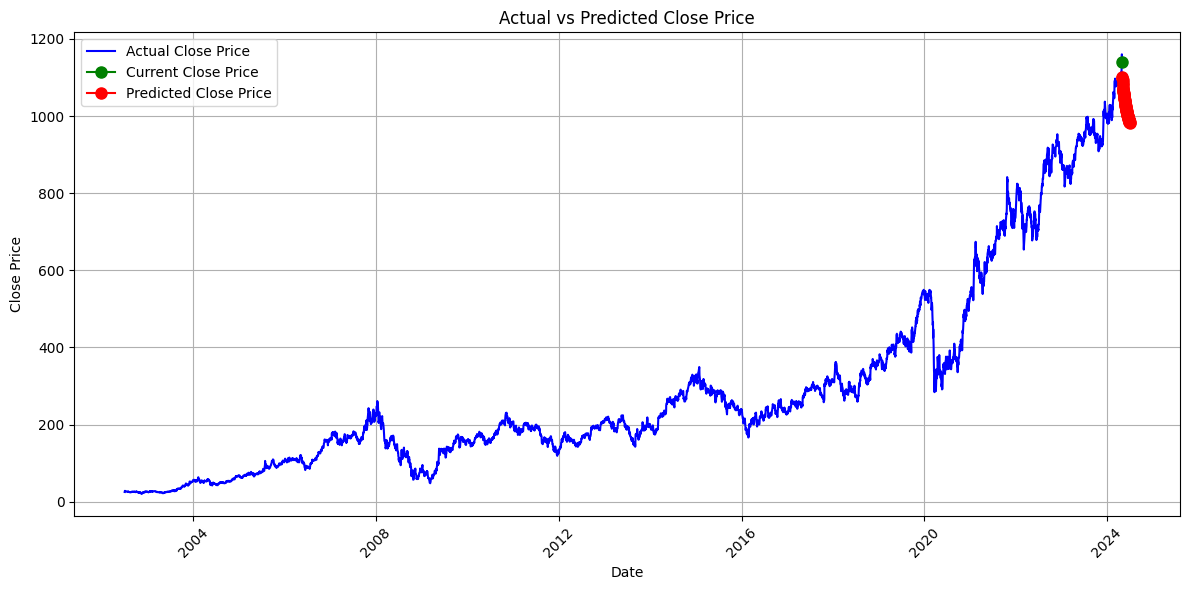

In [8]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
predicted_prices

array([1101.6931 , 1099.849  , 1093.4675 , 1086.0072 , 1079.3081 ,
       1073.9613 , 1069.8844 , 1066.747  , 1064.1942 , 1061.9404 ,
       1059.7909 , 1057.633  , 1055.4176 , 1053.1368 , 1050.8065 ,
       1048.4534 , 1046.1047 , 1043.7844 , 1041.5099 , 1039.2915 ,
       1037.1345 , 1035.0398 , 1033.0052 , 1031.0273 , 1029.1022 ,
       1027.2258 , 1025.3953 , 1023.6072 , 1021.8601 , 1020.15216,
       1018.4821 , 1016.8493 , 1015.2528 , 1013.69183, 1012.1658 ,
       1010.6737 , 1009.2151 , 1007.78894, 1006.39453, 1005.031  ,
       1003.6976 , 1002.3934 , 1001.1177 ,  999.8697 ,  998.6487 ,
        997.4539 ,  996.2848 ,  995.1406 ,  994.0209 ,  992.9248 ,
        991.8518 ,  990.8014 ,  989.773  ,  988.76605,  987.77997,
        986.8145 ,  985.86884,  984.94257,  984.0354 ,  983.1468 ],
      dtype=float32)

In [10]:
model.save('ICICIBANK.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
import joblib
joblib.dump(scaler, 'ICICIBANK.pkl')

['ICICIBANK.pkl']